In [3]:
!python --version

Python 3.5.2 :: Anaconda 4.2.0 (x86_64)


In [5]:
import os
import sys
import time
import pandas as pd
import datetime
#import pandas.io.data as web
from pandas_datareader import data
import matplotlib.pyplot as plt
from matplotlib import style
import glob
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import Activation, LSTM
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#import load_data
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

ImportError: No module named 'pandas_datareader'

In [4]:
def create_train_test(data):    
    X,y = data[:,0:-1], data[:, -1]     
    # Now split 80/20 for train and test data
    #train_count = int(.8*len(data))

    # last test_days is for test; the rest is for train
    test_days = 90
    train_count = len(data) - test_days

    X_train, X_test = X[:train_count], X[train_count:]
    y_train, y_test = y[:train_count], y[train_count:]
    return X_train, y_train, X_test, y_test

# define base model
def baseline_model(max_features=6):
    
    # create model
    model = Sequential()
    model.add(Dense(max_features*2, input_dim=max_features, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

'''
'''
def build_models(models_dir, supervised_data_dir):
    rmse_list = list()
    models = {}
    predicted_dfs = {}
    '''
    load supervised data 
    create and save models 
    '''
    csv_file_pattern = os.path.join(supervised_data_dir, "*.csv")
    csv_files = glob.glob(csv_file_pattern)
    dfs = {}
    print_first_model=True
    for filename in csv_files:
        data = pd.read_csv(filename, index_col='Date')
        #print(data.head())
        arr = filename.split('/')
        ticker = arr[-1].split('.')[0].split('_')[0]
        print('Processing', ticker)
        max_features = len(data.columns) -1
        X_train, y_train, X_test, y_test = create_train_test(data.values)
        model = baseline_model(max_features)
        if print_first_model:
            print(model.summary())
            print_first_model = False

        print('Training...')
        model.fit(X_train, y_train, batch_size=5, epochs=50, verbose=1, validation_data=(X_test, y_test))
        model_fname = os.path.join(models_dir, ticker + ".h5")
        print('Saving model to', model_fname)
        model.save(model_fname)


In [5]:
def create_supervised_filename(directory, ticker):
    return os.path.join(directory, ticker + "_supervised.csv")

'''
Predict and evaluate test data
'''
def predict_evaluate(models_dir, supervised_data_dir, rsme_csv):
    model_file_pattern = os.path.join(models_dir, "*.h5")
    model_files = glob.glob(model_file_pattern)
    predicted_dfs = {}
    rmse_list = list()
    print(model_file_pattern)
    
    for model_file in model_files:
        print('loading', model_file)
        arr = model_file.split('/')
        ticker = arr[-1].split('.')[0]
        '''
        Read supervised data and set up test data for prediction
        '''
        supervised_filename = create_supervised_filename(supervised_data_dir, ticker)
        data = pd.read_csv(supervised_filename, index_col='Date')
        X_train, y_train, X_test, y_test = create_train_test(data.values)


        print('Predicting...')
        model = load_model(model_file)
        predicted = model.predict(X_test)
        
        # Evaluate performance
        print("Evaluating test data...")
        loss_and_metrics = model.evaluate(X_test, y_test)
        print(model.metrics_names)
        print(loss_and_metrics)

        rmse = sqrt(mean_squared_error(y_test, predicted))
        print('Test RMSE: %.3f' % rmse)
        rmse_list += [[ticker,rmse]]
        predicted_dfs[ticker] = pd.DataFrame({'predicted': predicted.reshape(len(predicted)), 
                                              'actual': y_test.reshape(len(y_test))})


    rmse_df = pd.DataFrame(rmse_list, columns=['Stock Model', 'rsme'])
    rmse_df = rmse_df.sort_values(by='rsme')
    rmse_df.to_csv(rsme_csv)
    return predicted_dfs, rmse_df

In [6]:
models_dir = '../models/lstm_baseline/'
supervised_data_dir = '../data/samples2'
build_models(models_dir, supervised_data_dir)

Processing AAPL
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
None
Training...
Train on 6887 samples, validate on 90 samples
Epoch 1/50
6887/6887 [==============================] - 3s - loss: 1477880077.4522 - val_loss: 21849.3738

In [7]:
predicted_dfs, rmse_df = predict_evaluate(models_dir, supervised_data_dir, '../data/rsme_baseline.csv')

../models/lstm_baseline/*.h5
loading ../models/lstm_baseline/AAPL.h5
Predicting...
Evaluating test data...
32/90 [=========>....................] - ETA: 0s['loss']
17566.5935764
Test RMSE: 132.539
loading ../models/lstm_baseline/AMD.h5
Predicting...
Evaluating test data...
32/90 [=========>....................] - ETA: 0s['loss']
5.4925763766
Test RMSE: 2.344
loading ../models/lstm_baseline/FB.h5
Predicting...
Evaluating test data...
32/90 [=========>....................] - ETA: 0s['loss']
17808.106684
Test RMSE: 133.447
loading ../models/lstm_baseline/NDAQ.h5
Predicting...
Evaluating test data...
32/90 [=========>....................] - ETA: 0s['loss']
2806.82137044
Test RMSE: 52.979
loading ../models/lstm_baseline/NVDA.h5
Predicting...
Evaluating test data...
32/90 [=========>....................] - ETA: 0s['loss']
25141.6973958
Test RMSE: 158.561


In [8]:
rmse_df

,Stock Model,rsme
1,AMD,2.343625
3,NDAQ,52.979445
0,AAPL,132.539028
2,FB,133.447017
4,NVDA,158.561336


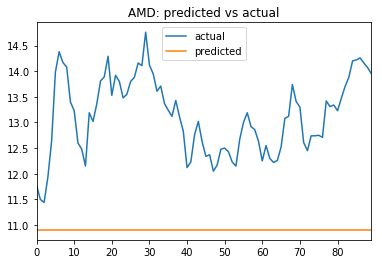

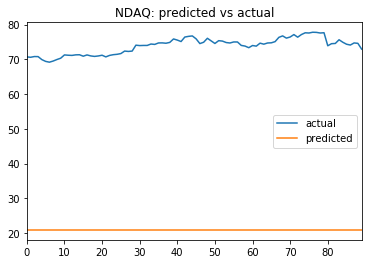

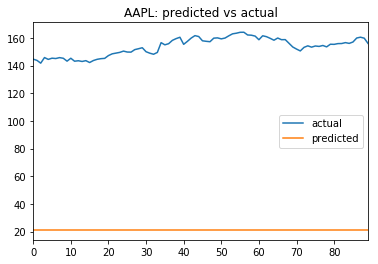

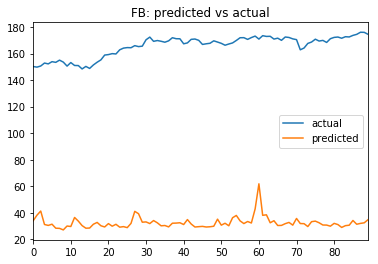

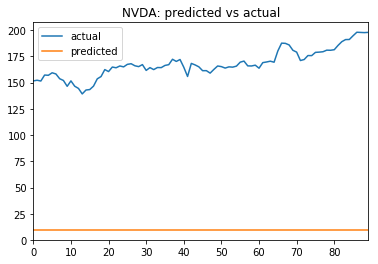

In [9]:
# Plot stocks based on rmse order (best -> worst)
for index, row in rmse_df.iterrows():
    key = row['Stock Model']
    predicted_dfs[key].plot(title=key + ': predicted vs actual')
    plt.show()